In [1]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
from rasterio.enums import Resampling
from rasterio.transform import from_origin
#
from shapely.geometry import Point
import whitebox
import math
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [2]:
def compress_geotiff_file(input_file, output_file, compression):
    # Open the input raster
    with rasterio.open(input_file) as src:
        data = src.read(1)  # Read the first band
        transform = src.transform
        no_data = src.nodata
        crs = src.crs
        rows, cols = src.shape
         
    # Write to output raster with compression
    with rasterio.open(
        output_file, 'w',
        driver='GTiff',
        height=rows, width=cols,
        count=1, dtype=data.dtype,
        crs=src.crs,
        transform=transform,
        nodata=np.nan,
        compress=compression  # Set compression
    ) as dst:
        dst.write(data, 1)

In [3]:
def convert_facc_river_network(input_file, output_file, threshold):
    # Open the input raster
    with rasterio.open(input_file) as src:
        data = src.read(1)  # Read the first band
        transform = src.transform
        no_data = src.nodata

    # Handle NoData values
    data = np.where(data == no_data, np.nan, data)
    data = np.where(data < threshold, np.nan, data)

    # Compute latitude for each pixel
    rows, cols = data.shape
    latitudes = transform[5] - np.arange(rows) * transform[0]
    
    # Update values based on the threshold
    for row in range(rows):
        data[row, data[row] >= threshold] = latitudes[row]

    # Multiply latitude and longitude values with the data  
    data = np.cos(data*np.pi/180.0)*111320.0*transform[0]
    data = np.square(data)+(111320.0*transform[0])**2
    data = np.sqrt(data)      
        
    # Write to output raster with compression
    with rasterio.open(
        output_file, 'w',
        driver='GTiff',
        height=rows, width=cols,
        count=1, dtype=data.dtype,
        crs=src.crs,
        transform=transform,
        nodata=np.nan #,
 #       compress=compression  # Set compression
    ) as dst:
        dst.write(data, 1)

In [4]:
def compute_zonal_statistics(input_shapefile, raster_file, output_shapefile, output_csv, column_name, statistics):
    # Read the shapefile into a GeoDataFrame
    gdf = gpd.read_file(input_shapefile)
    # Calculate zonal statistics
    stats = zonal_stats(gdf, raster_file, stats=statistics)
    # Convert the list of statistics to a DataFrame
    stats_df = pd.DataFrame(stats)
    # Rename the default column to the custom column name
    if len(statistics) == 1:  # If a single statistic is requested
        stats_df = stats_df.rename(columns={statistics[0]: column_name})
    else:  # If multiple statistics are requested
        stats_df = stats_df.rename(columns=lambda x: f"{column_name}_{x}")
    result_df = gdf[['COMID']].join(stats_df)
    # Save the result as a CSV file
    result_df.to_csv(output_csv, index=False)
    # Join the statistics DataFrame with the original GeoDataFrame for shapefile output
    gdf = gdf.join(stats_df)
    # Save the updated GeoDataFrame to a new shapefile
    gdf.to_file(output_shapefile)

In [5]:
def compute_zonal_statistics(input_shapefile, raster_file, output_shapefile, output_csv, column_name, statistics):
    # Read the shapefile into a GeoDataFrame
    gdf = gpd.read_file(input_shapefile)
    
    # Calculate zonal statistics
    stats = zonal_stats(gdf, raster_file, stats=statistics)
    
    # Convert the list of statistics to a DataFrame
    stats_df = pd.DataFrame(stats)
    
    # Rename the default column to the custom column name
    if len(statistics) == 1:  # If a single statistic is requested
        stats_df = stats_df.rename(columns={statistics[0]: column_name})
    else:  # If multiple statistics are requested
        stats_df = stats_df.rename(columns=lambda x: f"{column_name}_{x}")
    
    # Join the statistics DataFrame with the original GeoDataFrame, including 'COMID' and 'unitarea'
    result_df = gdf[['COMID', 'unitarea']].join(stats_df)
    
    # Save the result as a CSV file
    result_df.to_csv(output_csv, index=False)
    
    # Save the updated GeoDataFrame to a new shapefile
    gdf = gdf.join(stats_df)
    gdf.to_file(output_shapefile)
    
    # Return the updated GeoDataFrame
    return gdf


In [6]:
# Define the custom column name and statistics for the zonal statistics
column_name = 'mean_xslp'
statistics = 'mean'
# Define file paths
input_basin = '/scratch/fuaday/sras-agg-model/geofabric-outputs/sras_subbasins_MAF_Agg.shp'
input_data = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_slope_degree.tif'
gdf = gpd.read_file(input_basin)

In [7]:
# Load and visualize spatial dataset
def visualize_raster(file_path, title, cmap='viridis'):
    with rasterio.open(file_path) as src:
        data = src.read(1)
        fig, ax = plt.subplots(figsize=(10, 10))
        data[data == -9999] = np.nan
        im = ax.imshow(data, cmap=cmap, interpolation='none')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label('Value')  # You can customize this label
        ax.set_title(title)
        ax.set_xlabel('X-axis Label')  # Replace with actual label if needed
        ax.set_ylabel('Y-axis Label')  # Replace with actual label if needed
        plt.show()

In [8]:
# # Initialize WhiteboxTools
# wbt = whitebox.WhiteboxTools()
# wbt.verbose = False  # Set verbosity globally
# wbt.work_dir = "/scratch/fuaday/sras-agg-model/gistool-outputs/"

# # Calculate aspect in degrees
# wbt.aspect(
#     "sras_model_elv.tif", 
#     "sras_model_aspect_degree.tif", 
#     zfactor=None
# )

In [9]:
# Initialize WhiteboxTools
wbt = whitebox.WhiteboxTools()
wbt.verbose = False  # Set verbosity globally
wbt.work_dir = "/scratch/fuaday/sras-agg-model/gistool-outputs/"
# Calculate slope in degrees
wbt.slope(
    "sras_model_elv.tif", 
    "sras_model_slope_degree.tif", 
    zfactor=-1.0, 
    units="degrees"
)
# Calculate aspect in degrees
wbt.aspect(
    "sras_model_elv.tif", 
    "sras_model_aspect_degree.tif", 
    zfactor=-1.0
)

0

In [10]:
# compress pre-processed geotiff file
# Parameters
input_file = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_slope_degree.tif'
output_file = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_slope_degree2.tif'
compression = 'lzw'         # Compression method ('lzw', 'deflate', 'zstd', etc.)
# Compute and save
compress_geotiff_file(input_file, output_file, compression)

In [11]:
# compress pre-processed geotiff file
# Parameters
input_file = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_aspect_degree.tif'
output_file = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_aspect_degree2.tif'
compression = 'lzw'         # Compression method ('lzw', 'deflate', 'zstd', etc.)
# Compute and save
compress_geotiff_file(input_file, output_file, compression)

In [12]:
# Define file paths and threshold 
threshold = 0.1 #km2
input_file = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_upa.tif'
output_file = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_riv_0p1_2.tif'
# Compute and save zonal statistics
convert_facc_river_network(input_file, output_file, threshold)

In [15]:
# Define the custom column name and statistics for the zonal statistics
column_name = 'mean_xslp'
statistics = 'mean'
# Define file paths
input_basin = '/scratch/fuaday/sras-agg-model/geofabric-outputs/sras_subbasins_MAF_Agg.shp'
input_data = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_slope_degree.tif'
output_csv = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_slope_degree.csv'
# Compute and save zonal statistics
mean_xslp=compute_zonal_statistics(input_basin, input_data, input_basin, output_csv, column_name, statistics)


/tmp/ipykernel_25949/3032167159.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile)


In [22]:
mean_xslp['xslp'] = np.tan(mean_xslp['mean_xslp_mean'] * np.pi / 180.0)
print(list(mean_xslp.columns))

['COMID', 'unitarea', 'NextDownID', 'uparea', 'mean_xslp_', 'TotalRiv_s', 'mean_xsl_1', 'TotalRiv_1', 'TotalRiv_2', 'geometry', 'mean_xslp_mean', 'xslp']


In [24]:
output_csv = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_slope_degree.csv'
selected_columns = ['COMID', 'unitarea', 'xslp']  # Replace with the desired columns
# Create a new DataFrame with only the selected columns
selected_df = mean_xslp[selected_columns]
# Save the selected columns to a CSV file
selected_df.to_csv(output_csv, index=False)

In [9]:
column_name = 'TotalRiv'
statistics = 'sum'
# Define file paths
input_basin = '/scratch/fuaday/sras-agg-model/geofabric-outputs/sras_subbasins_MAF_Agg.shp'
input_data = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_riv_0p1_2.tif'
output_csv = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_riv_0p1_2.csv'
# Compute and save zonal statistics
TotalRiv = compute_zonal_statistics(input_basin, input_data, input_basin, output_csv, column_name, statistics)

/tmp/ipykernel_25949/3032167159.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile)


In [25]:
output_csv = '/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_riv_0p1_2.csv'
TotalRiv['dd']=TotalRiv['TotalRiv_sum']/TotalRiv['unitarea'] / 1000000.0
print(list(TotalRiv.columns))
# Select the columns you want to save
selected_columns = ['COMID', 'unitarea', 'dd']  # Replace with the desired columns
# Create a new DataFrame with only the selected columns
selected_df = TotalRiv[selected_columns]
# Save the selected columns to a CSV file
selected_df.to_csv(output_csv, index=False)

['COMID', 'unitarea', 'NextDownID', 'uparea', 'mean_xslp_', 'TotalRiv_s', 'mean_xsl_1', 'TotalRiv_1', 'geometry', 'TotalRiv_sum', 'dd']


<AxesSubplot:>

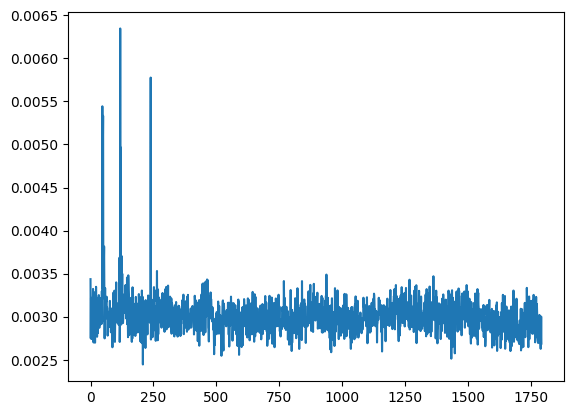

In [13]:
TotalRiv.dd.plot()

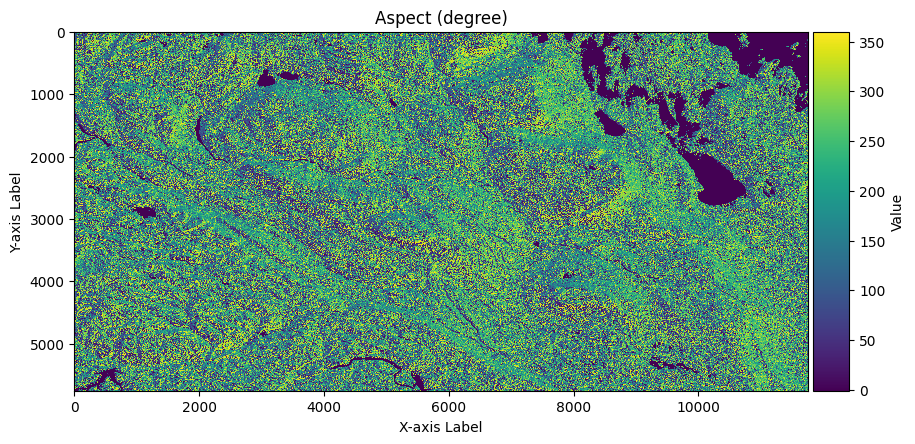

In [15]:
# Load input data add the title of the data for visualization
input_data_path='/scratch/fuaday/sras-agg-model/gistool-outputs/sras_model_aspect_degree.tif'
visualize_raster(input_data_path, "Aspect (degree)")

In [ ]:
# Load input data add the title of the data for visualization
input_data_path='/scratch/zelalem/CanTrans-models/gistool-outputs/merit_hydro/aspect_degree_90m_2.tif'
visualize_raster(input_data_path, "Aspect (degree)")